In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import expr
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
from pyspark.sql.functions import isnan, when, count, col, date_format, hour
import numpy as np
from pyspark.sql import functions as F
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/23 21:10:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [20]:
sdf = spark.read.parquet('../data/curated/*')
zones = spark.read.csv('../data/taxi_zones/taxi+_zone_lookup.csv', \
                       header=True, inferSchema=True)
wsdf = spark.read.parquet('../data/weather_curated/*')
JFK_AIRPORT = 132

In [4]:
# drop irrelevant columns that we dont need to train the model on
sdf = sdf.drop('VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', \
                'store_and_fwd_flag', 'payment_type', 'fare_amount', 'extra', \
                'mta_tax', 'tip_amount', 'tolls_amount', \
                'improvement_surcharge', 'total_amount', \
                'congestion_surcharge', 'airport_fee')

## lets start doing some modelling using weather data
### we will fit linear model and see if these have an affect on weather data

In [5]:
agg_by_date_loc = (sdf.groupby(date_format('tpep_pickup_datetime', \
                                        'yyyy-MM-dd').alias('pickup_date'), \
                                        'PULocationID') \
                                    .count() \
                                    .withColumnRenamed('count', 'total_trips'))


# Joining with weather data
wsdf2 = agg_by_date_loc.join(wsdf, agg_by_date_loc.pickup_date == wsdf.date, \
                            'inner').drop('pickup_date') 


In [6]:
df = wsdf2.toPandas()
# Add a constant term to allow statsmodels to fit an intercept
df['const'] = 1

# Predictor variables (weather attributes + location)
predictor_vars = ['const', 'PULocationID', 'avg_wind_speed', 'precipitation', 
                  'snowfall','avg_temp'
]
X = df[predictor_vars]


# Response variable
y = df['total_trips']

model1 = sm.OLS(y, X).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:            total_trips   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     732.5
Date:                Wed, 23 Aug 2023   Prob (F-statistic):               0.00
Time:                        21:11:33   Log-Likelihood:            -8.7791e+05
No. Observations:              105003   AIC:                         1.756e+06
Df Residuals:                  104997   BIC:                         1.756e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            125.6259     12.840      9.

In [7]:
# Extract the day of the week
sdf_with_day = agg_by_date_loc.withColumn("day_of_week",\
                              date_format(col("pickup_date"), "E"))

# Create a new column that represents 1 for weekday and 0 for weekend
sdf_with_weekday = sdf_with_day.withColumn("is_weekday", \
                                            when(col("day_of_week") \
                                            .isin(["Sat", "Sun"]), 0) \
                                            .otherwise(1))
sdf3 = sdf_with_weekday.drop('day_of_week')

df = sdf3.toPandas()
# Add a constant term to allow statsmodels to fit an intercept
df['const'] = 1

# Predictor variables (weather attributes + location)
predictor_vars = ['const', 'PULocationID', 'is_weekday'
]
X = df[predictor_vars]


# Response variable
y = df['total_trips']

model2 = sm.OLS(y, X).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            total_trips   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1824.
Date:                Wed, 23 Aug 2023   Prob (F-statistic):               0.00
Time:                        21:11:47   Log-Likelihood:            -8.7792e+05
No. Observations:              105003   AIC:                         1.756e+06
Df Residuals:                  105000   BIC:                         1.756e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          140.5304      8.321     16.888   

In our analysis we saw that Manhattan has the most taxi demand but also JFK
airport not being in Manhattan but still have significant demand so in our
analysis of fitting logistic regression we will be using PU location belong to
Manhattan and JFK airport

In [8]:
filtered_zones = zones.filter(
    (F.col("Borough") == "Manhattan") | 
    (F.col("Zone") == "JFK Airport")
)

# Perform the join
filtered_sdf = sdf.join(
    filtered_zones, 
    sdf.PULocationID == filtered_zones.LocationID, 
    "inner"
).drop(filtered_zones.LocationID)

### lets fit Random forest to predict total trips using location ID, significant
### weather data (avg_temp, snowfall), hour of the day

In [9]:
# as we saw from linear regression snowfall and avg temp are significant 
# to predict the number of trips so lets use them as well in our final model

# aggregate by date, hour and location
agg_by_date_hour_loc = (filtered_sdf \
                        .groupby(date_format('tpep_pickup_datetime', \
                                            'yyyy-MM-dd') \
                                            .alias('pickup_date'), \
                                hour('tpep_pickup_datetime') \
                                    .alias('hour_of_day'), \
                                'PULocationID') \
                        .count()
                        .withColumnRenamed('count', 'total_trips'))

# join with weather data
result_sdf = agg_by_date_hour_loc \
            .join(wsdf, agg_by_date_hour_loc.pickup_date == wsdf2.date, \
                'inner')

# now sort the data by date and hour
result_sdf = result_sdf.sort(F.col("pickup_date"), F.col("hour_of_day"))

# drop irrelevant columns
drop_col = ['station', 'name', 'date', 'avg_wind_speed', 
            'precipitation', 'max_temp', 'min_temp'
]
result_sdf = result_sdf.drop(*drop_col)

In [10]:
result_sdf.show(1, vertical = True)

-RECORD 0------------------
 pickup_date  | 2022-01-01 
 hour_of_day  | 0          
 PULocationID | 74         
 total_trips  | 9          
 snowfall     | 0.0        
 avg_temp     | 10.1       
only showing top 1 row



In [11]:
# now split the data for training and testing
# training data spans from Feb 2022 to Jan 2023
# testing data spans from Feb 2023 to May 2023
train_sdf = result_sdf.filter((F.col("pickup_date") >= "2022-02-01") & 
                            (F.col("pickup_date") <= "2023-01-31"))

test_sdf = result_sdf.filter((F.col("pickup_date") >= "2023-02-01") & 
                           (F.col("pickup_date") <= "2023-05-31"))

train = train_sdf.count()
test = test_sdf.count()
print(train)
print(test)
print(f"{train/(test+train)*100}%")
# drop pickup date
train_sdf = train_sdf.drop('pickup_date')
test_sdf = test_sdf.drop('pickup_date')

507436
165578
75.39754002145573%


### LGTM! we have 75 to 25 split for train and test data

In [12]:
# data size is not much larger can use pandas to fit the model
train_df = train_sdf.toPandas()
test_df = test_sdf.toPandas()

# For the training data:
X_train = train_df.drop("total_trips", axis=1)  # Features
y_train = train_df["total_trips"]               # Response variable

# For the test data:
X_test = test_df.drop("total_trips", axis=1)    # Features
y_test = test_df["total_trips"]                 # Response variable

In [13]:
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 4]
}

rfr = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 30}


In [15]:
best_rfr = grid_search.best_estimator_
y_train_pred = best_rfr.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"RMSE on training data = {train_rmse}")


y_test_pred = best_rfr.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE on test data = {test_rmse}")

RMSE on training data = 24.35370995728961
RMSE on test data = 35.753106320079


In [18]:
def plot_graph(y_pred, y_actual, X_vals, loc_ID):

    predictions = y_pred
    area_name = ''

    # Create a new DataFrame to hold hour_of_day, actual and predicted trips
    # Keep 'hour_of_day' and 'PULocationID'
    result_df = X_vals[['hour_of_day', 'PULocationID']].copy()
    result_df['actual_trips'] = y_actual.values
    result_df['predicted_trips'] = predictions

    if (loc_ID == 0):
        location_specific_df = result_df
    elif (loc_ID == 132):
        # Filter for only rows where PULocationID is 132
        location_specific_df = result_df[result_df['PULocationID'] == loc_ID]
        area_name = 'for JFK Airport'
    else:
        # Filter for only rows where PULocationID is not 132 (Manhattan area)
        location_specific_df = result_df[result_df['PULocationID'] != 132]
        area_name = 'for Manhattan'
    

    # Group by 'hour_of_day' and calculate the sum of 'total_trips' for actual 
    # and predicted
    grouped = location_specific_df.groupby('hour_of_day').agg({
        'actual_trips': 'sum',
        'predicted_trips': 'sum'
    }).reset_index()

    # Plotting
    plt.figure(figsize=(12, 6))

    # Actual values
    plt.plot(grouped['hour_of_day'], grouped['actual_trips'], label='Actual', \
            color='blue')

    # Predicted values
    plt.plot(grouped['hour_of_day'], grouped['predicted_trips'], \
            label='Predicted', color='red', linestyle='--')

    plt.xticks(range(0, 25, 3))

    plt.title('Actual vs. Predicted Taxi Trips per Hour ' + area_name)
    plt.xlabel('Hour of Day')
    plt.ylabel('Total Trips')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # save plot
    #plt.savefig(output_dir + '.png')
    plt.show()

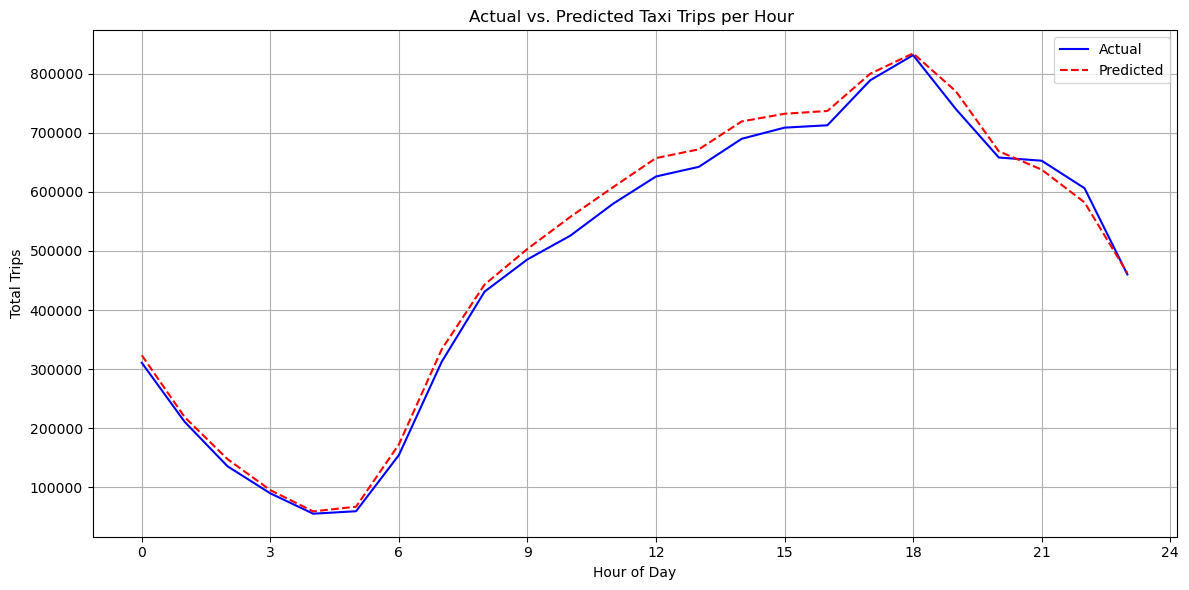

In [25]:
plot_graph(y_test_pred, y_test, X_test, 0)

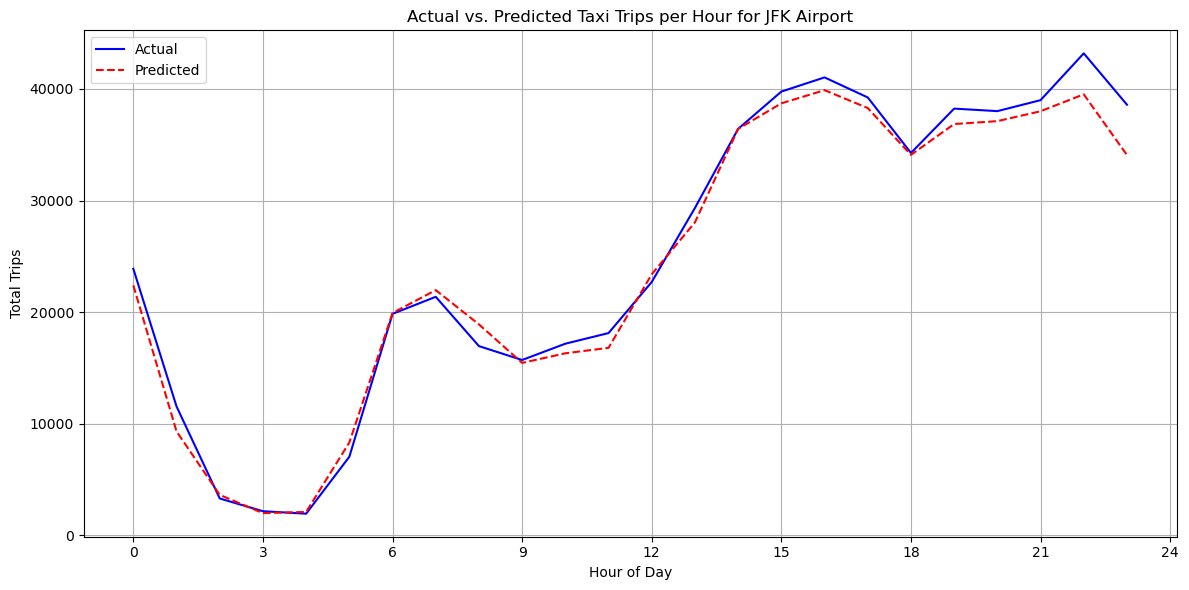

In [26]:
plot_graph(y_test_pred, y_test, X_test, JFK_AIRPORT)

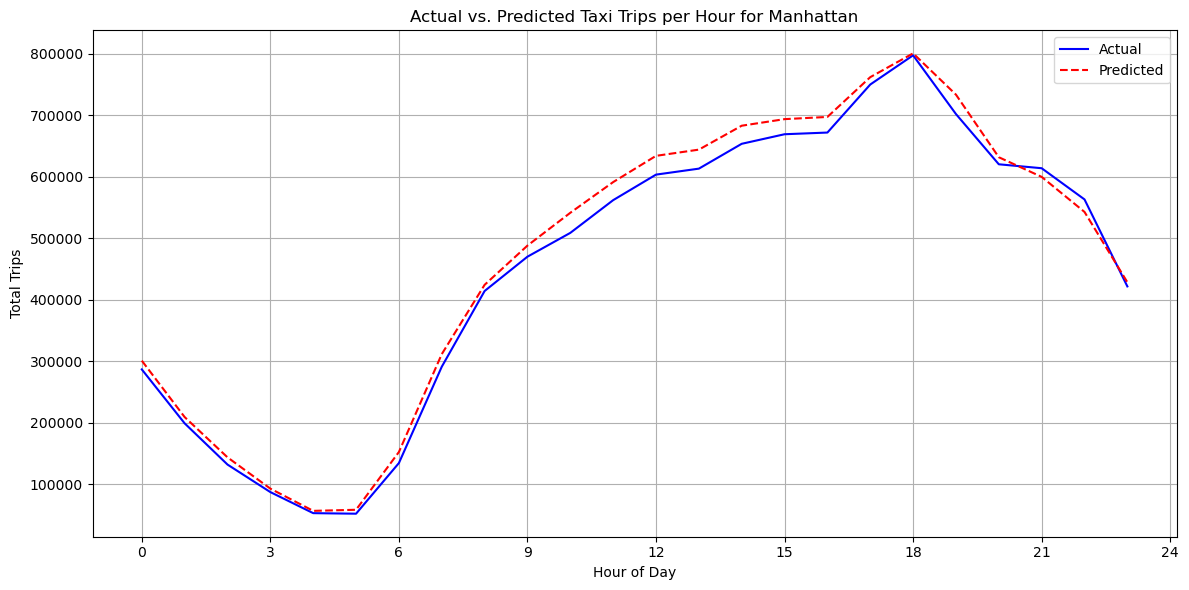

In [27]:
plot_graph(y_test_pred, y_test, X_test, JFK_AIRPORT-1)